The Annotated S4. https://srush.github.io/annotated-s4/. by Sasha Rush and Sidd Karamcheti, v3. 
- - -

In [1]:
# ================================================
#  Library
# ================================================
from functools import partial
import jax
import jax.numpy as np
from flax import linen as nn
from jax.nn.initializers import lecun_normal, normal
from jax.numpy.linalg import eigh, inv, matrix_power
from jax.scipy.signal import convolve

## Part 1: State Space Models

$$
x'(t) = \mathbf{A}x(t) + \mathbf{B}u(t) \\
y(t) = \mathbf{C}x(t) + \mathbf{D}u(t)
$$

$\mathbf{A, B, C, D}$がパラメータ。今回は$\mathbf{D}u$という項はスキップ接続と見なすことができ、計算が簡単であるため$\mathbf{D}$は$0$とする。  
$u_{t}$をinput, $x(t), y(t)$がoutput。

In [4]:
def random_SSM(rng, N: int):
    """A, B, Cの値をランダムに設定する
    Args:
        rng: a PRNG key (from ``PRNGKey``, ``split``, ``fold_in``).
        N(int): 正方行列A, B, Cの行数または列数

    Returns:
        パラメータA, B, C
    """
    a_r, b_r, c_r = jax.random.split(rng, 3)
    A = jax.random.uniform(a_r, (N, N))
    B = jax.random.uniform(b_r, (N, N))
    C = jax.random.uniform(c_r, (N, N))
    return A, B, C

### Discrete-time SSM: The Recurrent Representation

連続関数である$u_{t}$の代わりに離散$(u_{0}, u_{1}, \dots)$にすることで、SSMは**step size** $\Delta$で離散化しなければならない。離散化するためにbilinear method(双一次変換)を用いる。

$$
\bar{\mathbf{A}} = (\mathbf{I} - \Delta/2・\mathbf{A})^{-1}(\mathbf{I}+ \Delta/2・\mathbf{A}) \\
\bar{\mathbf{B}} = (\mathbf{I} - \Delta/2・\mathbf{A})^{-1}\Delta \mathbf{B}\\
\bar{\mathbf{C}} = \mathbf{C}
$$

$u_{k}$は$u(t)$からのサンプルだと考えることができる。$u_{k} = u(k\Delta)$

In [ ]:
def discretize(A, B, C, step):
    """uの離散化に伴ってSSMのパラメータも変化させる

    Args:
        A, B, C: 状態空間モデルのパラメータ
        step: 離散化させる幅

    return:
        変化させたパラメータA, B, C
    """
    I = np.eye(A.shape[0]) # np.eye(N: int): 単位行列
    BL = inv(I - (step / 2.0) * A) # inv: 逆行列
    Ab = BL @ (I + (step / 2.0) * A) # @: 行列の積
    Bb = (BL * step) @ B
    return Ab, Bb, C

uを離散化したことでsequence-to-sequenceとなる。$u_{k} \mapsto y_{k}$   
さらに状態方程式(the state equation)は$x_{k}$によって再帰されているのでdiscrete-SSMはRNNのように計算することができる。具体的には$x_{k} \in \mathbb{R}^{N}$はhidden_stateとして考えられる。

$$
x_{k} = \bar{\mathbf{A}}x_{k-1} + \bar{\mathbf{B}}u_{k} \\
y_{k} = \bar{\mathbf{C}}x_{k}
$$

In [ ]:
def scan_SSM(Ab, Bb, Cb, u, x0):
    """パラメータをRNNのように再帰的に求める

    Args:
        Ab, Bb, Cb: 状態空間モデルのパラメータ
        u: 入力
        x0: xの初期状態
    """
    def step(x_k_1, u_k):
        x_k = Ab @ x_k_1 + Bb @ u_k
        y_k = Cb @ x_k
        return x_k, y_k
    return jax.lax.scan(f = step, init = x0, xs = u)

In [ ]:
def run_SSM(A, B, C, u):
    L = u.shape[0]
    N = A.shape[0]
    Ab, Bb, Cb = discretize(A, B, C, step=1.0/L)

    return scan_SSM(Ab, Bb, Cb, u[:, np.newaxis], np.zeros((N, )))[1]

### Training SSMs: The Convolutional Representation
目的：RNNをCNNに変換して計算を高速化する

線形時不変状態空間モデルと連続的なたたみ込みにはよく知られた関連性がある。そしてthe recurrent SSMは実はdiscrete convolutionとして表せる。 
$x_{-1}=0$とすると
$$
x_{0} = \bar{\mathbf{B}}u_{0}, x_{1} = \bar{\mathbf{A}}\bar{\mathbf{B}}u_{0} + \bar{\mathbf{B}}u_{1}, \dots \\
y_{0} = \bar{\mathbf{C}}\bar{\mathbf{B}}u_{0}, y_{1} = \bar{\mathbf{C}}\bar{\mathbf{A}}\bar{\mathbf{B}}u_{0}+ \bar{\mathbf{C}}\bar{\mathbf{B}}u_{1}, y_{2} = \bar{\mathbf{C}}\bar{\mathbf{A}}^{2}\bar{\mathbf{B}}u_{0} + \bar{\mathbf{C}}\bar{\mathbf{A}}\bar{\mathbf{B}}u_{1} + \bar{\mathbf{C}}\bar{\mathbf{B}}u_{2}, \dots
$$

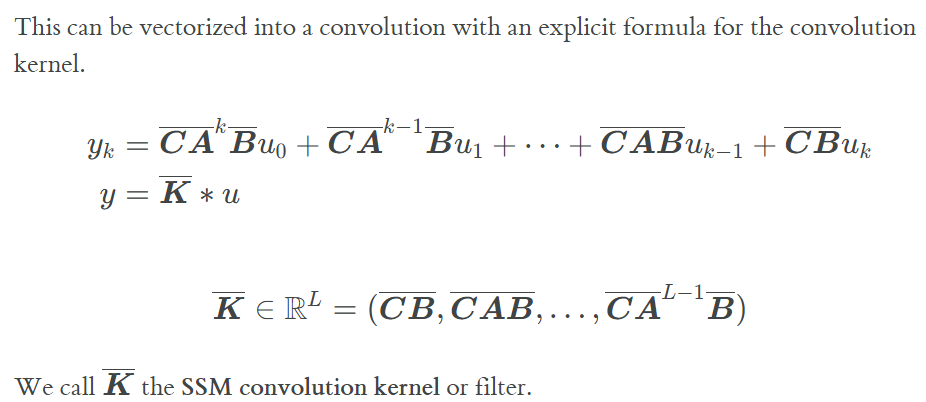

In [ ]:
def K_conv(Ab, Bb, Cb, L):
    # matrix_power: 行列の累乗
    return np.array(
        [(Cb @ matrix_power(Ab, n=l) @ Bb).reshape() for l in range(L)]
    )
#実装は不安定で非常に短い長さを超えると機能しない。あとで書きかえる。

このフィルタを適用した結果を計算する方法として、標準的な直接畳み込みや高速フーリエ変換（FFT）を用いた畳み込み定理を使用することができます。離散畳み込みの定理（二つの系列の循環畳み込みの場合）により、入力系列のFFTを掛け合わせ、逆FFTを適用することで効率的に畳み込みの出力を計算することができます。私たちの場合は循環畳み込みではないため、この定理を非循環畳み込みに利用するためには、入力系列をゼロでパディングし、出力系列を元の長さに戻す必要があります。入力系列の長さが長くなるほど、このFFT法は直接畳み込みよりも効率的になります。

具体的に言うと、FFTを使用した畳み込みでは、入力系列をFFTに変換することで周波数領域での乗算が行われます。その後、逆FFTを適用することで時間領域に戻し、畳み込みの結果を得ることができます。非循環畳み込みでは、入力系列をゼロでパディングすることで、FFTの長さを調整し、出力系列を元の長さに戻すことで正確な結果を得ることができます。

このFFT法を使用すると、入力系列の長さが長くなるほど計算効率が向上します。従って、直接畳み込みよりも高速に畳み込みを行うことができます。ただし、パディングや逆パディングによる余分な処理が必要となるため、計算効率と処理のオーバーヘッドのトレードオフを考慮する必要があります。

In [ ]:
def causal_convolution(u, k, nofft=False):
    if nofft:
        return convolve(u, k, mode="full")[:, u.shape[0]]
    else:
        assert K.shape[0] == u.shape[0]
        ud = np.fft.rfft(np.pad(u, (0, K.shape[0])))
        Kd = np.fft.rfft(np.pad(K, (0, u.shape[0])))
        out = ud * kd
        return np.fft.irfft(out)[:, u.shape[0]]

In [ ]:
def test_cnn_is_rnn(N=4, L=16, step=1.0/16):
    ssm = random_SSM(rng, N)
    u = jax.random.uniform(rng, (L, ))
    jax.random.split(rng, 3)

    # RNN
    rec = run_SSM(*ssm, step=step)

    # CNN
    ssmb = discretize(*ssm, step=step)
    conv = causal_convolution(u, K_conv(*ssmb, L))
    
    # chech if cnn result is the same as rnn result
    assert np.allclose(rec.rabel(), conv.rabel())

### An SSM Neural Network

In [ ]:
def log_step_initializer(dt_min=0.001, dt_max=0.1):
    def init(key, shape):
        return jax.random.uniform(key, shape) * (
            np.log(dt_max) - np.log(dt_min)
        ) + np.log(dt_min)
    return init

In [ ]:
class SSMLayer(nn.Module):
    N: int
    l_max: int
    decode: bool = False

    def setup(self):
        # SSM parameters
        self.A = self.param("A", lecun_normal(), (self.N, self.K))
        self.B = self.param("B", lecun_normal(), (self.N, self.K))
        self.C = self.param("C", lecun_normal(), (self.N, self.K))
        self.D = self.param("D", lecun_normal(), (self.N, self.K))

        # step parameter
        self.log_step = self.param("log_step", log_step_initializer(), (1, ))


        step = np.exp(self.log_step)
        self.ssm = discretize(self.A, self.B, self.C, step=step)
        self.K = K_conv(*self.ssm, self.l_max)

        # RNN cashe for Long sequences
        self.x_k_1 = self.variable("cashe", "cashe_x_k", np.zeros, (self.N, ))

    def __call__(self, u):
        if not self.decode:
            # CNN mode
            return causal_convolution(u, self.K) + self.D * u
        else:
            # RNN mode
            x_k, y_s = scan_SSM(*self.ssm, u[:, np.newaxis], self.x_k_1.value)
            if self.is_mutable_collection("cashe"):
                self.x_k_1.value = x_k
            return y_s.reshape(-1).real + self.D * u

In [ ]:
def cloneLayer(layer):
    return nn.vmap(
        layer,
        in_axes=1,
        out_axes=1,
        variable_axes = {"params":1, "cashe":1, "prime";1},
        split_rngs={"params":True},
    )